In [ ]:
from prepare_data import create_flickr_dataloaders
from encoder import ImageEncoder
from decoder import CaptionDecoder
import torch
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def generate_caption(encoder, decoder, image_tensor, vocab_info, device, max_length=20):
    """Generate caption for a single image"""
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        # Extract image features
        image_features = encoder(image_tensor.unsqueeze(0).to(device))
        
        # Start with START token
        caption = [vocab_info['start_token']]
        
        for _ in range(max_length):
            caption_tensor = torch.tensor([caption]).to(device)
            outputs = decoder(caption_tensor, image_features)
            
            # Get next word
            next_word = outputs[0, -1, :].argmax().item()
            caption.append(next_word)
            
            # Stop if END token
            if next_word == vocab_info['end_token']:
                break
    
    return caption

In [ ]:
def decode_caption(caption_ids):
    """Convert caption IDs back to text"""
    with open('Processed Data/decode_vocab.json', 'r') as f:
        decode_vocab = json.load(f)
    
    words = []
    for idx in caption_ids:
        word = decode_vocab[str(idx)]
        if word not in ['<START>', '<END>', '<PAD>']:
            words.append(word)
    
    return ' '.join(words)

In [ ]:
def plot_sample_prediction(encoder, decoder, test_loader, vocab_info, device, epoch):
    """Plot a sample image with predicted caption from TEST SET"""
    import random
    
    random.seed(epoch + 42)
    
    batch_idx = random.randint(0, len(test_loader) - 1)
    
    for i, batch in enumerate(test_loader):
        if i == batch_idx:
            images = batch['images']
            image_ids = batch['image_ids']
            
            # Random pick một sample trong batch
            local_idx = random.randint(0, len(images) - 1)
            
            sample_image = images[local_idx]
            sample_id = image_ids[local_idx]
            
            # Generate caption
            predicted_caption = generate_caption(encoder, decoder, sample_image, vocab_info, device)
            predicted_text = decode_caption(predicted_caption)
            
            # Load and display image
            img_path = f"Flickr8k/Flicker8k_Dataset/{sample_id}"
            image_pil = Image.open(img_path).convert('RGB')
            
            plt.figure(figsize=(10, 6))
            plt.imshow(image_pil)
            plt.axis('off')
            plt.title(f'Epoch {epoch + 1} - Image: {sample_id}\nPredicted: {predicted_text}', 
                     fontsize=12, wrap=True)
            plt.tight_layout()
            plt.show()
            
            print(f"Epoch {epoch + 1} - TEST Image: {sample_id}")
            print(f"Predicted Caption: {predicted_text}")
            break

In [23]:
def validate(encoder, decoder, val_loader, criterion, device, vocab_info):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            
            image_features = encoder(images)
            outputs = decoder(captions[:, :-1], image_features)
            targets = captions[:, 1:]
            
            loss = criterion(outputs.reshape(-1, vocab_info['vocab_size']), 
                           targets.reshape(-1))
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

In [ ]:
train_loader, val_loader, test_loader, vocab_info = create_flickr_dataloaders(batch_size=32)

FlickrDataset train loaded:
  Images: 6000
  Image-caption pairs: 30000
  Vocab size: 2549
  Max length: 15
FlickrDataset val loaded:
  Images: 1000
  Image-caption pairs: 5000
  Vocab size: 2549
  Max length: 15
FlickrDataset test loaded:
  Images: 1000
  Image-caption pairs: 5000
  Vocab size: 2549
  Max length: 15


In [ ]:
def train_model(train_loader, val_loader, vocab_info, num_epochs=10):
    
    # Initialize models
    encoder = ImageEncoder(embed_dim=512)
    decoder = CaptionDecoder(vocab_info['vocab_size'], embed_dim=512)
    
    criterion = nn.CrossEntropyLoss(ignore_index=vocab_info['pad_token'])
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), 
                          lr=1e-4, weight_decay=1e-3)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder.to(device)
    decoder.to(device)
    
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            
            # Forward pass
            image_features = encoder(images)
            outputs = decoder(captions[:, :-1], image_features)
            
            # Calculate loss
            targets = captions[:, 1:]
            loss = criterion(outputs.reshape(-1, vocab_info['vocab_size']), 
                           targets.reshape(-1))
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_idx}, Loss: {loss.item():.4f}')
        
        # Validation
        val_loss = validate(encoder, decoder, val_loader, criterion, device, vocab_info)
        train_loss = total_loss / len(train_loader)
        
        print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Plot sample prediction FROM TEST SET
        plot_sample_prediction(encoder, decoder, test_loader, vocab_info, device, epoch)
        
        # Save checkpoint
        torch.save({
            'encoder_state': encoder.state_dict(),
            'decoder_state': decoder.state_dict(),
        }, f'Models/checkpoint_epoch_{epoch + 1}.pth')
    torch.save({
            'encoder_state': encoder.state_dict(),
            'decoder_state': decoder.state_dict(),
        }, f'Models/captioning_model.pth')

Epoch 1, Batch 0, Loss: 7.9568
Epoch 1, Batch 200, Loss: 4.0940
Epoch 1, Batch 400, Loss: 3.3027
Epoch 1, Batch 600, Loss: 3.4185
Epoch 1, Batch 800, Loss: 2.9416
Epoch 1: Train Loss: 3.6714, Val Loss: 3.2463


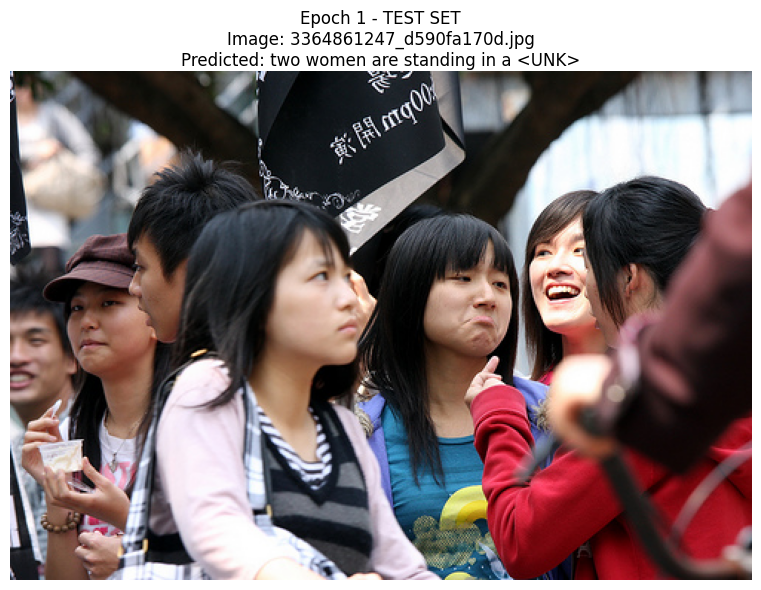

Epoch 1 - TEST Image: 3364861247_d590fa170d.jpg
Predicted Caption: two women are standing in a <UNK>
Epoch 2, Batch 0, Loss: 2.9366
Epoch 2, Batch 200, Loss: 3.2392
Epoch 2, Batch 400, Loss: 2.9070
Epoch 2, Batch 600, Loss: 2.9595
Epoch 2, Batch 800, Loss: 2.9646
Epoch 2: Train Loss: 3.0776, Val Loss: 3.0948


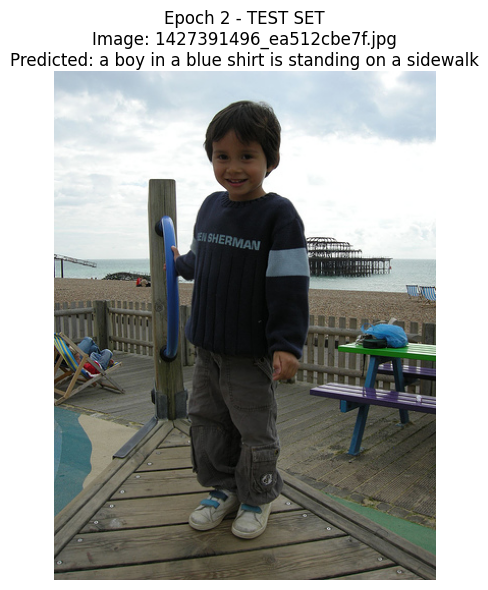

Epoch 2 - TEST Image: 1427391496_ea512cbe7f.jpg
Predicted Caption: a boy in a blue shirt is standing on a sidewalk
Epoch 3, Batch 0, Loss: 3.1309
Epoch 3, Batch 200, Loss: 3.3386
Epoch 3, Batch 400, Loss: 3.0171
Epoch 3, Batch 600, Loss: 3.0090
Epoch 3, Batch 800, Loss: 2.9546
Epoch 3: Train Loss: 2.9293, Val Loss: 3.0185


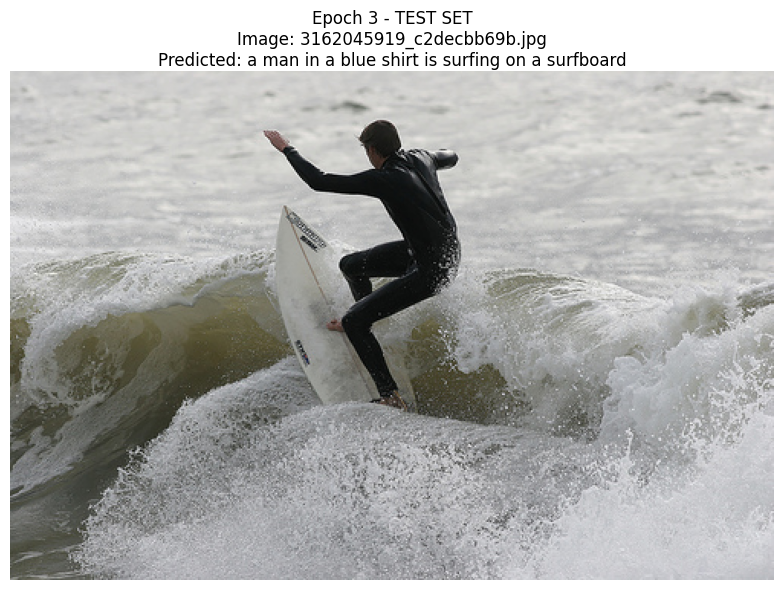

Epoch 3 - TEST Image: 3162045919_c2decbb69b.jpg
Predicted Caption: a man in a blue shirt is surfing on a surfboard
Epoch 4, Batch 0, Loss: 2.9255
Epoch 4, Batch 200, Loss: 2.8007
Epoch 4, Batch 400, Loss: 2.7641
Epoch 4, Batch 600, Loss: 2.6806
Epoch 4, Batch 800, Loss: 2.7861
Epoch 4: Train Loss: 2.8495, Val Loss: 2.9779


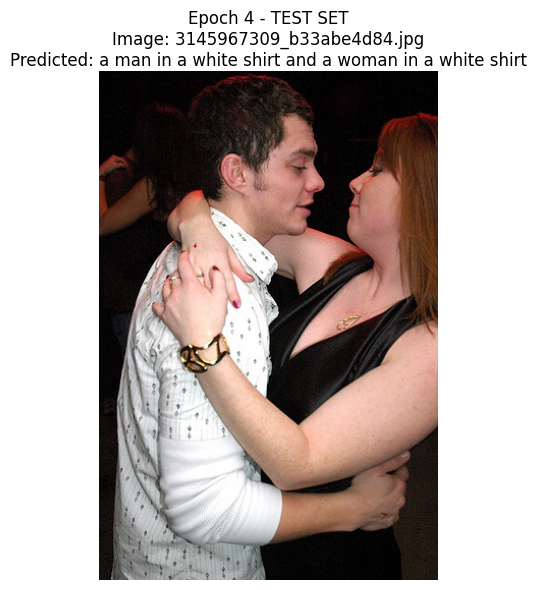

Epoch 4 - TEST Image: 3145967309_b33abe4d84.jpg
Predicted Caption: a man in a white shirt and a woman in a white shirt
Epoch 5, Batch 0, Loss: 2.4941
Epoch 5, Batch 200, Loss: 2.6774
Epoch 5, Batch 400, Loss: 2.8585
Epoch 5, Batch 600, Loss: 2.8550
Epoch 5, Batch 800, Loss: 2.7729
Epoch 5: Train Loss: 2.7984, Val Loss: 2.9728


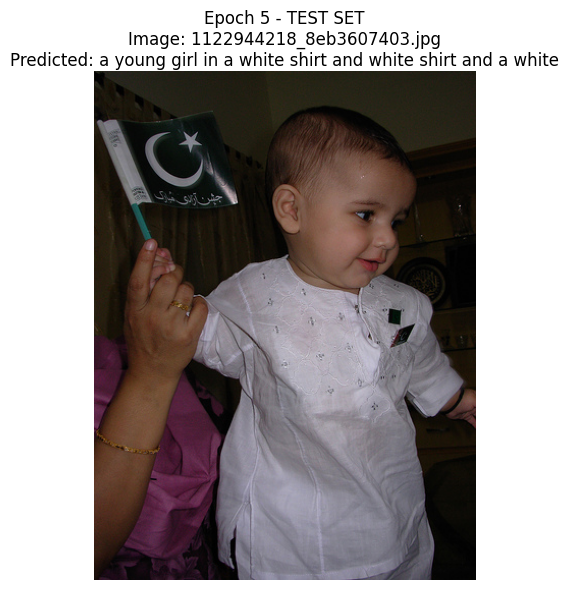

Epoch 5 - TEST Image: 1122944218_8eb3607403.jpg
Predicted Caption: a young girl in a white shirt and white shirt and a white
Epoch 6, Batch 0, Loss: 2.9262
Epoch 6, Batch 200, Loss: 2.7138
Epoch 6, Batch 400, Loss: 2.8367
Epoch 6, Batch 600, Loss: 2.7109
Epoch 6, Batch 800, Loss: 2.9291
Epoch 6: Train Loss: 2.7646, Val Loss: 2.9703


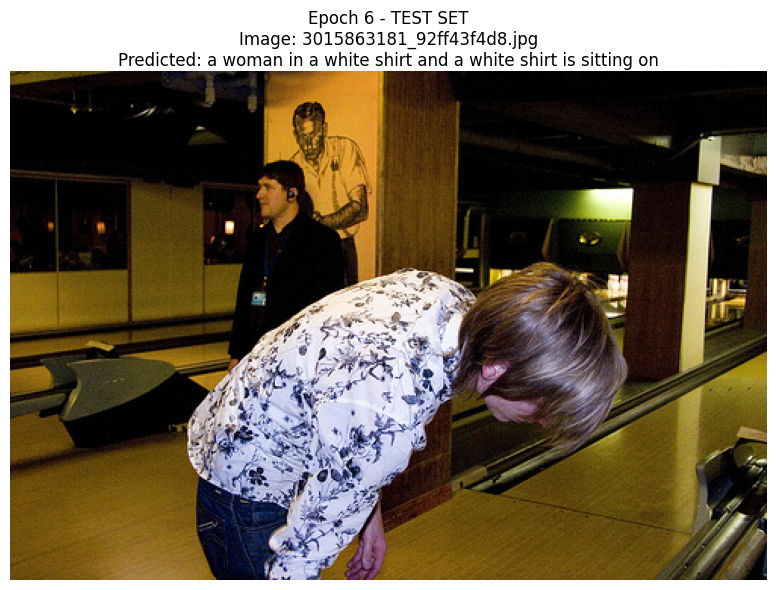

Epoch 6 - TEST Image: 3015863181_92ff43f4d8.jpg
Predicted Caption: a woman in a white shirt and a white shirt is sitting on
Epoch 7, Batch 0, Loss: 2.9029
Epoch 7, Batch 200, Loss: 2.6669
Epoch 7, Batch 400, Loss: 2.7783
Epoch 7, Batch 600, Loss: 2.5364
Epoch 7, Batch 800, Loss: 2.7976
Epoch 7: Train Loss: 2.7431, Val Loss: 2.9635


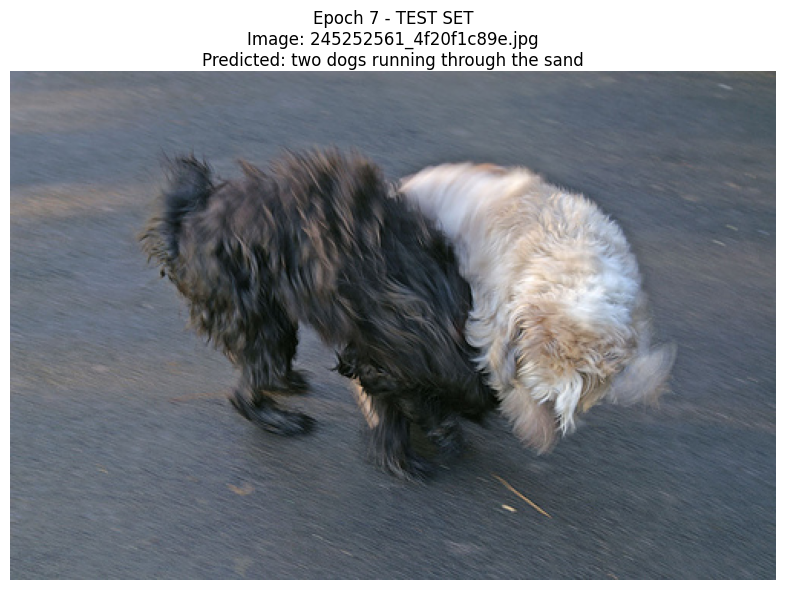

Epoch 7 - TEST Image: 245252561_4f20f1c89e.jpg
Predicted Caption: two dogs running through the sand
Epoch 8, Batch 0, Loss: 2.7117
Epoch 8, Batch 200, Loss: 2.9227
Epoch 8, Batch 400, Loss: 2.8502
Epoch 8, Batch 600, Loss: 2.8885
Epoch 8, Batch 800, Loss: 2.7798
Epoch 8: Train Loss: 2.7292, Val Loss: 2.9825


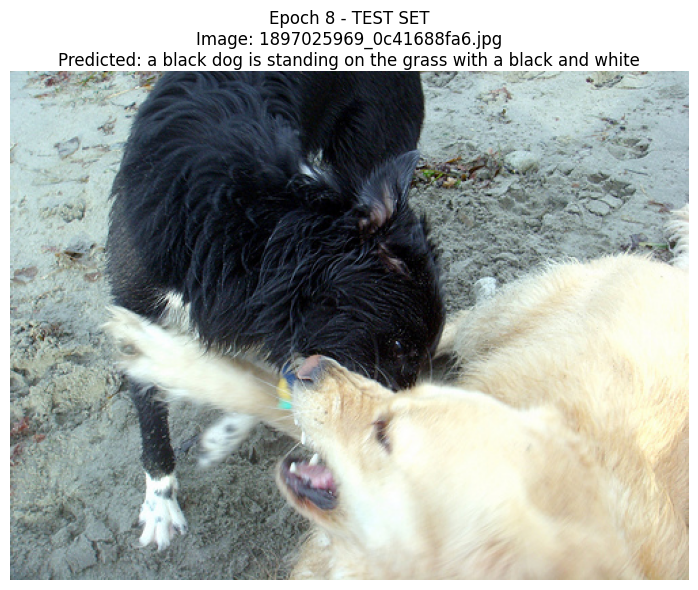

Epoch 8 - TEST Image: 1897025969_0c41688fa6.jpg
Predicted Caption: a black dog is standing on the grass with a black and white
Epoch 9, Batch 0, Loss: 2.5144
Epoch 9, Batch 200, Loss: 2.6582
Epoch 9, Batch 400, Loss: 2.7161
Epoch 9, Batch 600, Loss: 3.0998
Epoch 9, Batch 800, Loss: 2.6817
Epoch 9: Train Loss: 2.7187, Val Loss: 2.9824


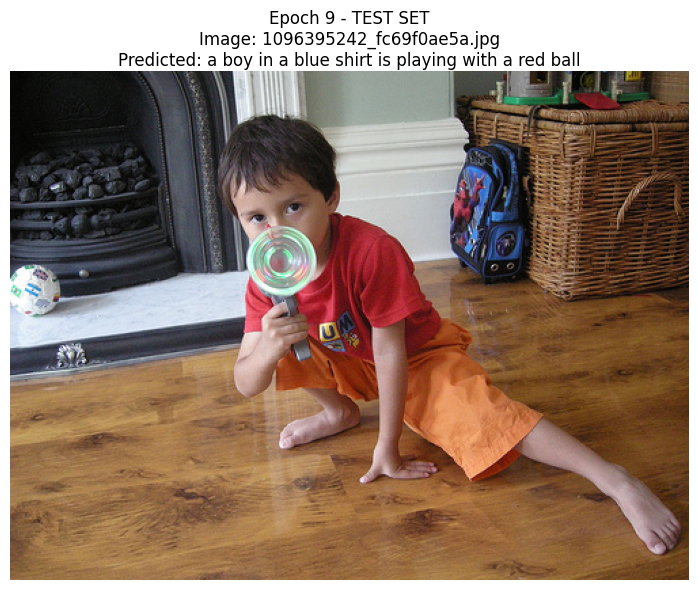

Epoch 9 - TEST Image: 1096395242_fc69f0ae5a.jpg
Predicted Caption: a boy in a blue shirt is playing with a red ball
Epoch 10, Batch 0, Loss: 2.6450
Epoch 10, Batch 200, Loss: 2.7397
Epoch 10, Batch 400, Loss: 2.5402
Epoch 10, Batch 600, Loss: 2.9759
Epoch 10, Batch 800, Loss: 2.6703
Epoch 10: Train Loss: 2.7100, Val Loss: 2.9787


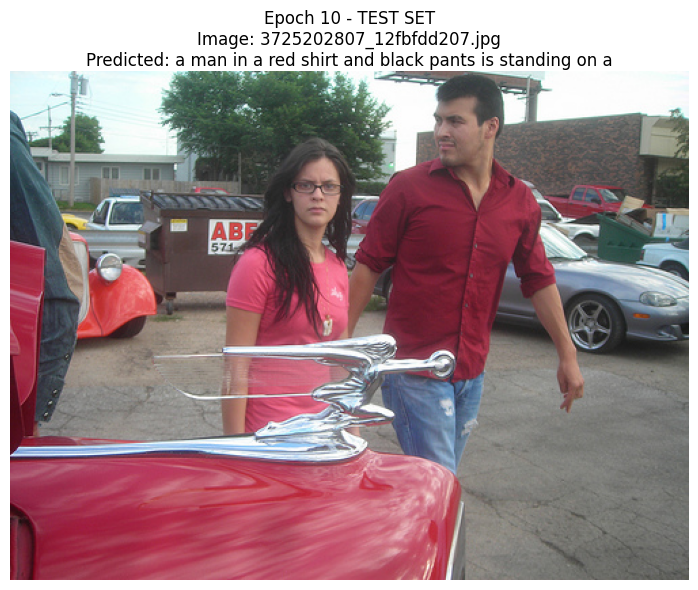

Epoch 10 - TEST Image: 3725202807_12fbfdd207.jpg
Predicted Caption: a man in a red shirt and black pants is standing on a


In [27]:
train_model(train_loader, val_loader, vocab_info, num_epochs=10)

In [28]:
def evaluate_model(encoder, decoder, test_loader, vocab_info, device):
    """Comprehensive evaluation on test set"""
    from collections import Counter
    import numpy as np
    
    encoder.eval()
    decoder.eval()
    
    all_predictions = []
    all_targets = []
    total_samples = 0
    correct_predictions = 0
    
    print("🔍 Evaluating model on test set...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            image_ids = batch['image_ids']
            
            batch_size = len(images)
            total_samples += batch_size
            
            # Generate predictions for each image
            for i in range(batch_size):
                # Generate caption
                predicted_caption = generate_caption(encoder, decoder, images[i], vocab_info, device)
                predicted_text = decode_caption(predicted_caption)
                
                # Get target caption (first caption for this image)
                target_caption = captions[i]
                target_text = decode_caption(target_caption.cpu().tolist())
                
                all_predictions.append(predicted_text)
                all_targets.append(target_text)
                
                # Simple accuracy: check if any target word appears in prediction
                pred_words = set(predicted_text.lower().split())
                target_words = set(target_text.lower().split())
                if len(pred_words.intersection(target_words)) > 0:
                    correct_predictions += 1
            
            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx * batch_size} / {len(test_loader.dataset)} samples")
    
    # Calculate metrics
    accuracy = correct_predictions / total_samples
    
    # Word frequency analysis
    pred_words = []
    target_words = []
    for pred, target in zip(all_predictions, all_targets):
        pred_words.extend(pred.lower().split())
        target_words.extend(target.lower().split())
    
    pred_counter = Counter(pred_words)
    target_counter = Counter(target_words)
    
    print("\n📊 EVALUATION RESULTS:")
    print(f"Total test samples: {total_samples}")
    print(f"Word overlap accuracy: {accuracy:.3f}")
    print(f"Average prediction length: {np.mean([len(p.split()) for p in all_predictions]):.1f} words")
    print(f"Average target length: {np.mean([len(t.split()) for t in all_targets]):.1f} words")
    
    print(f"\n🔤 Most common predicted words:")
    for word, count in pred_counter.most_common(10):
        print(f"  {word}: {count}")
    
    print(f"\n🎯 Most common target words:")
    for word, count in target_counter.most_common(10):
        print(f"  {word}: {count}")
    
    # Show sample predictions
    print(f"\n📝 SAMPLE PREDICTIONS:")
    for i in range(min(10, len(all_predictions))):
        print(f"Target:    {all_targets[i]}")
        print(f"Predicted: {all_predictions[i]}")
        print("---")
    
    return {
        'accuracy': accuracy,
        'total_samples': total_samples,
        'predictions': all_predictions,
        'targets': all_targets,
        'pred_word_freq': pred_counter,
        'target_word_freq': target_counter
    }

In [29]:
def calculate_bleu_score(predictions, targets):
    """Calculate BLEU score (simplified version)"""
    from collections import Counter
    
    total_score = 0
    for pred, target in zip(predictions, targets):
        pred_words = pred.lower().split()
        target_words = target.lower().split()
        
        if len(pred_words) == 0:
            continue
            
        # 1-gram precision
        pred_counter = Counter(pred_words)
        target_counter = Counter(target_words)
        
        overlap = 0
        for word in pred_counter:
            overlap += min(pred_counter[word], target_counter.get(word, 0))
        
        precision = overlap / len(pred_words) if len(pred_words) > 0 else 0
        total_score += precision
    
    return total_score / len(predictions) if len(predictions) > 0 else 0

In [ ]:
# Load trained model và test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('Models/checkpoint_epoch_10.pth', map_location=torch.device(device)) 

# Initialize models
encoder = ImageEncoder(embed_dim=512)
decoder = CaptionDecoder(vocab_info['vocab_size'], embed_dim=512)

encoder.to(device)
decoder.to(device)

# Load weights
encoder.load_state_dict(checkpoint['encoder_state'])
decoder.load_state_dict(checkpoint['decoder_state'])

print("🎯 Model loaded! Starting evaluation...")

# Run evaluation
results = evaluate_model(encoder, decoder, test_loader, vocab_info, device)

# Calculate BLEU score
bleu = calculate_bleu_score(results['predictions'], results['targets'])
print(f"\n🎯 BLEU Score: {bleu:.3f}")

# Diversity analysis
unique_predictions = len(set(results['predictions']))
print(f"\n🔍 DIVERSITY ANALYSIS:")
print(f"Unique predictions: {unique_predictions} / {results['total_samples']} ({unique_predictions/results['total_samples']:.3f})")

🎯 Model loaded! Starting evaluation...
🔍 Evaluating model on test set...
Processed 0 / 5000 samples
Processed 320 / 5000 samples
Processed 640 / 5000 samples
Processed 960 / 5000 samples
Processed 1280 / 5000 samples
Processed 1600 / 5000 samples
Processed 1920 / 5000 samples
Processed 2240 / 5000 samples
Processed 2560 / 5000 samples
Processed 2880 / 5000 samples
Processed 3200 / 5000 samples
Processed 3520 / 5000 samples
Processed 3840 / 5000 samples
Processed 4160 / 5000 samples
Processed 4480 / 5000 samples
Processed 4800 / 5000 samples

📊 EVALUATION RESULTS:
Total test samples: 5000
Word overlap accuracy: 0.963
Average prediction length: 10.3 words
Average target length: 10.2 words

🔤 Most common predicted words:
  a: 11225
  in: 3955
  is: 3435
  shirt: 2465
  on: 1730
  man: 1640
  and: 1505
  <unk>: 1475
  black: 1300
  red: 1215

🎯 Most common target words:
  a: 7518
  in: 2166
  the: 2157
  <unk>: 1534
  on: 1288
  is: 1147
  and: 969
  dog: 931
  with: 919
  man: 910

📝 SAMP